In [1]:
#!/usr/bin/python3
# import tensorflow as tf
import numpy as np
from math import exp
from numpy.random import binomial,shuffle,seed, choice
import pandas as pd
from IPython.display import display, clear_output
import os
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import CompactLSM

seed(4) # for replicating results

Reservoir Dimension set

In [2]:
nx = 5
ny = 5
nz = 5
N = nx*ny*nz                                          # Reservoir size

N_read = 10                                           # No. of Readout neurons

Important constants related to LIF neuron and synaptic model

In [3]:
global vrest, vth, t_refrac
vrest, vth, t_refrac = 0, 20, 2

tau_m = 32
params_potential = {'C':1, 'g_L':1/tau_m, 'E_L':vrest, 'V_T':vth, 'R_p':t_refrac}

Delay = 1 #constant delay for all synapses in ms

tau_c = 64
C_theta = 5
del_C = 3
n_bits = 8
delta_c = 1
params_conc = {'C_theta':C_theta, 'del_C':del_C, 'tau_c':64, 'nbits':n_bits, 'delta_c':delta_c}

syn_string = "first-order"

sampling_freq = 12.5 # in khz
h = 1 # in ms

time_params = {'h':h, 'Delay':Delay}

Set Reservoir Connections

In [4]:
# Storing the IDs of the neurons
LSM_ID = np.zeros((nx,ny,nz),dtype=np.int64)
l = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            LSM_ID[i,j,k] = l
            l = l + 1

# Storing the synapse connections, and creating the initial weight matrix

k_prob = [0.45, 0.3, 0.6, 0.15]
r_sq = 2**2

W_arr = [3, 6, -2, -2]
W_init = 3
Weights_temp = np.zeros((N,N))

N_in = int(N*0.8)
neuron_type = [ int(i<N_in) for i in range(N)]
seed(4)
shuffle(neuron_type) # 1 for excitatory, 0 for inhibitory

synapes = [dict() for i in range(N)]    # an array of dictonaries which store the location of neuron, 
                                        # type of neuron, and the IDs of the neurons it is connected to

for l in range(N):
    loc = CompactLSM.ID_to_ind(nx,ny,nz,l)
    n_type = neuron_type[l]
    cons = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if l != int(LSM_ID[i,j,k]):
                    dist_sq = (loc[0]-i)**2 + (loc[1]-j)**2 + (loc[2]-k)**2
                    k_probl = 0
                    if n_type == 1:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[0]
                        W_init = W_arr[0]
                      else:
                        k_probl = k_prob[1]
                        W_init = W_arr[1]
                    else:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[2]
                        W_init = W_arr[2]
                      else:
                        k_probl = k_prob[3]
                        W_init = W_arr[3]

                    probability = k_probl* exp(-1*dist_sq/r_sq)
#                     print(probability)
                    check = binomial(1,probability)
                    if check == 1:
                        cons.append(int(LSM_ID[i,j,k]))
                        Weights_temp[l,int(LSM_ID[i,j,k])] = W_init    
    synapes[l] = {"Location":loc, "Neuron_type":n_type, "connections":cons}

global Weights
Weights = Weights_temp
print("Total synapse:", len(np.argwhere(Weights!=0)), 
        ",E --> E :", len(np.argwhere(Weights==3)), 
        ",E --> I:",len(np.argwhere(Weights==6)),
        ",I --> E/I:",len(np.argwhere(Weights==-2)))
i = 64
print("Total Connections: for neuron {}:{}, {}".format(i,synapes[i]["Neuron_type"],synapes[i]["connections"]) )

Total synapse: 1130 ,E --> E : 769 ,E --> I: 105 ,I --> E/I: 256
Total Connections: for neuron 64:1, [19, 62, 83, 84, 89, 93, 97, 109, 114, 118]


Set Readout neuron initial Weights

In [5]:
All_labels = [str(x) for x in range(10)]
# N_read = 10                                           # No. of Readout neurons
W_init_read = 1                                       # Initial weight, equal for all, update with learning
Weights_temp_readOut = W_init_read*np.ones((N_read, N), dtype='float')


synapes_read = []        # an array of dictonaries which store the label of neuron, 
                                                      # and the IDs of the neurons it is connected to

for l in range(N_read):
    label = All_labels[l]
    synapes_read.append(label)

Weights_readOut = Weights_temp_readOut

In [6]:
# creating file location and label arrays for train and validate

base = 'PreProcessing/trainBSA'
os.listdir(base)

train_Labels = []
file_name_List = []

for human in os.listdir(base):
    base_up = base + '/' + human
    for train_sample in os.listdir(base_up):
        train_Label = train_sample[0:2]
        file_loc = base_up + '/' + train_sample
        file_name_List.append(file_loc)
        train_Labels.append(train_Label)

seedval = 4

seed(seedval)
shuffle(train_Labels)
seed(seedval)
shuffle(file_name_List)

total_size = len(train_Labels)
train_size = int(total_size*0.8)

validate_Labels = train_Labels[train_size:total_size]
validate_file_list = file_name_List[train_size:total_size]

train_Labels = train_Labels[0:train_size]
train_file_list = file_name_List[0:train_size]

In [7]:
L = 78
Fin = 4
reservoir_ID = [i for i in range(N)]
seed(seedval)
Input_CXNs = choice(reservoir_ID, size = (L,Fin))
sign_win_matrix = (binomial(1,1/2, size = (L, Fin)) - 0.5)*2
# Input_CXNs * sign_win_matrix

### Finding input neurons to reservoir current and then using the spike train to find the current input to the reservoir

In [8]:
# print("Input neurons =",L)
print("Size of Reservoir =",nx,"X",ny,"X",nz,",Total total neurons =",N)
print("Total no.of read out neurons =",N_read)

Size of Reservoir = 5 X 5 X 5 ,Total total neurons = 125
Total no.of read out neurons = 10


In [9]:
# # if need to exit training load last trained weights, else comment 
# made del_w 0.1 from 0.01 at 57th epoch
load_idx = 38
Weights_readOut_fromCsv = pd.read_csv("Weights_1stOrder/weights_epoch{}.csv".format(load_idx), sep=",", header=None)
Weights_readOut = Weights_readOut_fromCsv.to_numpy()
Weights_readOut_fromCsv = Weights_readOut_fromCsv.iloc[1:, 1:]
Weights_readOut = Weights_readOut_fromCsv.to_numpy()
Weights_readOut

array([[-4.35, -8.05, -0.3 , ..., -8.  ,  1.  ,  0.6 ],
       [-2.1 ,  6.25,  5.35, ...,  6.95,  1.  , -1.9 ],
       [-3.9 , -8.05,  6.15, ..., -8.05,  1.  , -6.05],
       ...,
       [-0.9 , -8.  , -1.  , ..., -8.05,  1.  , -0.45],
       [-2.65, -8.  ,  3.1 , ..., -7.95,  1.  , -0.9 ],
       [-4.2 ,  1.25,  5.3 , ...,  7.6 ,  1.  , -4.15]])

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (6.4 * 3, 4.8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)

### solving the reservoir

Epoch: 36, Training input: 480, Classified label: 1, Actual label: 1, Spikes: [ 0. 32.  0.  0.  0.  0.  0.  0.  0.  0.]
Last Epoch Training rate:100.0
**************************************************
Validate input: 120, Classified label: 8, Actual label: 2,  Spikes: [16. 11. 20. 19. 18. 16. 14. 15. 24. 16.]
Last Epoch validation rate:34.17


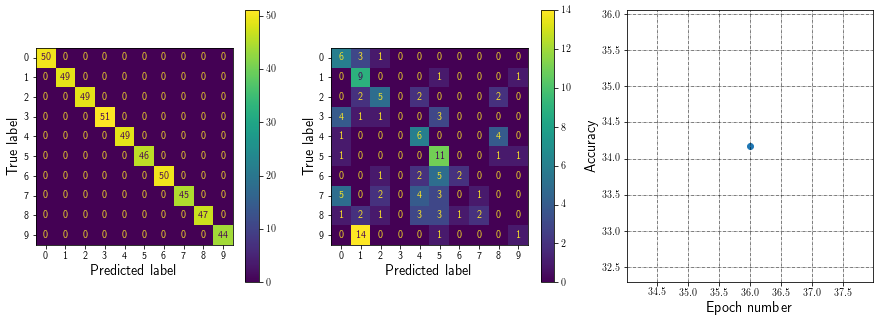

Epoch: 37, Training input: 480, Classified label: 1, Actual label: 1, Spikes: [ 0. 32.  0.  0.  0.  0.  0.  0.  0.  0.]
Last Epoch Training rate:100.0
**************************************************
Validate input: 120, Classified label: 8, Actual label: 2,  Spikes: [16. 11. 20. 19. 18. 16. 14. 15. 24. 16.]
Last Epoch validation rate:30.0


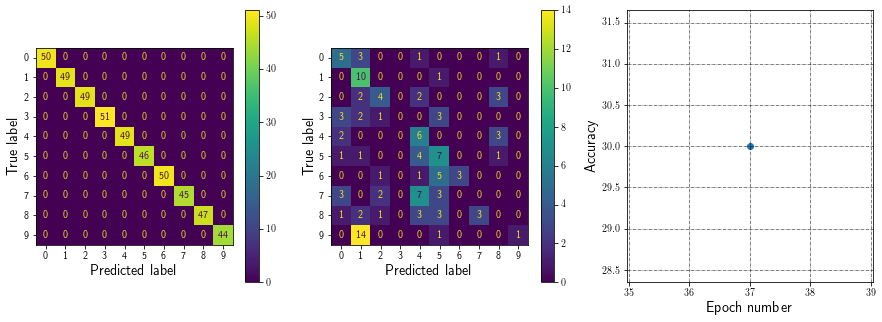

Epoch: 38, Training input: 480, Classified label: 1, Actual label: 1, Spikes: [ 0. 32.  0.  0.  0.  0.  0.  0.  0.  0.]
Last Epoch Training rate:100.0
**************************************************
Validate input: 120, Classified label: 8, Actual label: 2,  Spikes: [16. 10. 20. 19. 18. 16. 13. 15. 24. 17.]
Last Epoch validation rate:33.33


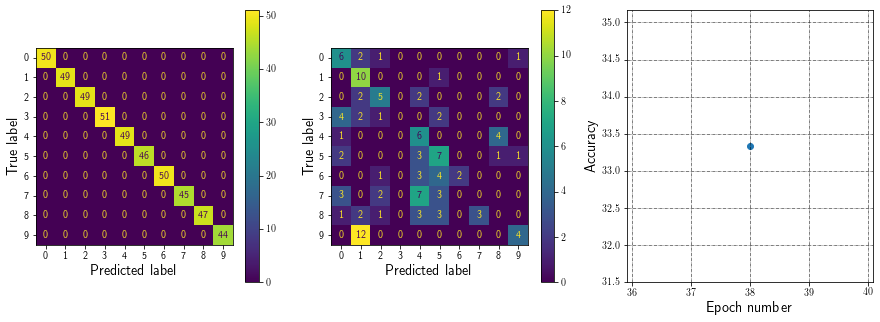

Epoch: 39, Training input: 18, Classified label: 4, Actual label: 4, Spikes: [ 0.  1.  0.  0. 34.  0.  0.  0.  0.  0.]

KeyboardInterrupt: 

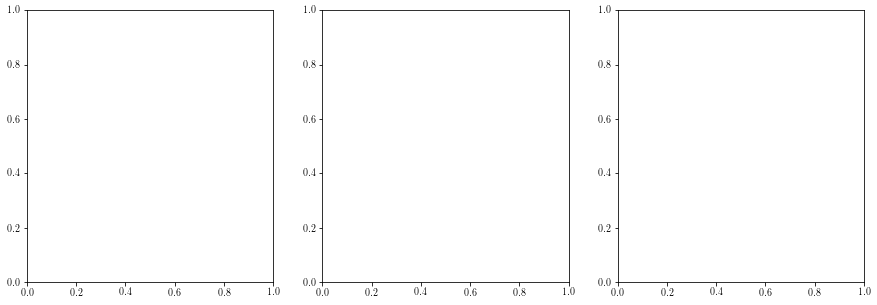

In [11]:
# Training
EPOCHS = 200 # From paper
All_reservoir_spikes = []
Weights_epoch_save = []
prediction_rate = np.zeros((EPOCHS,))
Validation_rate = np.zeros((EPOCHS,))
Validation_accuracies, epochs_here = [],[]
for epoch in range(35, 500):
    print("="*50)
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    
    correct_predictions = 0
    True_labels, classified_labels = [], []
    Input_gen_func = CompactLSM.Input_current_gen(train_file_list, syn_string, N, time_params,Input_CXNs,
                                                  sign_win_matrix,training=True, train_Labels=train_Labels)
    NUM_INPUTS = len(train_Labels)
    
    for i in range(NUM_INPUTS):
        In_app, L, M, train_Label,input_num = next(Input_gen_func)      # Generates next input   

        [Reservoir_potential, Reservoir_Spikes] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app, 
                                                                          params_potential, Weights, syn_string)

        All_reservoir_spikes.append(Reservoir_Spikes)
        Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(N_read,N, Delay, synapes, M,
                                                                                         h, Reservoir_Spikes, 
                                                                                         params_potential,params_conc,
                                                                                         Weights_readOut,syn_string,
                                                                                         training=True,
                                                                                         train_ids=[train_Label])

        class_out_label, class_out_idx, No_of_spikes= CompactLSM.classifier(Readout_Spikes,synapes_read)
        Weights_readOut = trained_weights
        
        display_string = "Epoch: {}, Training input: {}, Classified label: {}, Actual label: {}, Spikes: {}".format(
            epoch + 1, i + 1, class_out_label, train_Label, No_of_spikes)
        print("\r"+display_string,end="")

        True_labels.append(int(train_Label)); classified_labels.append(int(class_out_label))    
        if int(class_out_label) == int(train_Label):
            correct_predictions += 1
#     break
    Weights_epoch_save.append(Weights_readOut)
    prediction_rate[epoch] = correct_predictions/NUM_INPUTS
    
    path = "Weights_1stOrder/"; file = "weights_epoch{}.csv".format(epoch + 1)
    pd.DataFrame(Weights_readOut).to_csv(path + file)
    display_string = "Last Epoch Training rate:{}".format(prediction_rate[epoch] * 100)
    print("\n" + display_string)
    
    cm_train = confusion_matrix(True_labels, classified_labels, labels=[i for i in range(10)])
    disp_train = ConfusionMatrixDisplay(confusion_matrix= cm_train,display_labels=[i for i in range(10)])
    disp_train.plot(ax=ax1)
    print("*"*50)
    
    ############### Online learning Validation ###################
    Input_gen_func = CompactLSM.Input_current_gen(validate_file_list, syn_string, N, time_params,
                                                  Input_CXNs,sign_win_matrix, training=True, train_Labels=validate_Labels)
    NUM_INPUTS = len(validate_Labels)

    correct_predictions = 0
    True_labels, classified_labels = [], []
    for i in range(NUM_INPUTS):
        In_app, L, M, validate_Label,input_num = next(Input_gen_func)      # Generates next input   

        [Reservoir_potential, Reservoir_Spikes] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app, 
                                                                            params_potential, Weights, syn_string)
        

        Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(N_read,N, Delay, synapes, M,
                                                                                            h, Reservoir_Spikes, 
                                                                                            params_potential,params_conc,
                                                                                            Weights_readOut,syn_string,
                                                                                            training=False,
                                                                                         train_ids=[validate_Label])
        
        class_out_label, class_out_idx, No_of_spikes= CompactLSM.classifier(Readout_Spikes,synapes_read)
#         Weights_readOut = trained_weights

        display_string = "Validate input: {}, Classified label: {}, Actual label: {},  Spikes: {}".format(
            i + 1, class_out_label, validate_Label, No_of_spikes)
        print("\r"+display_string,end="")

        True_labels.append(int(validate_Label)); classified_labels.append(int(class_out_label))
        if int(class_out_label) == int(validate_Label):
            correct_predictions += 1

    Validation_rate[epoch] = correct_predictions/NUM_INPUTS
    display_string = "Last Epoch validation rate:{}".format(np.round(Validation_rate[epoch]*100, 2))
    print("\n" + display_string)
    
    cm_validate = confusion_matrix(True_labels, classified_labels, labels=[i for i in range(10)])
    disp_validate = ConfusionMatrixDisplay(confusion_matrix=cm_validate,display_labels=[i for i in range(10)])
    disp_validate.plot(ax=ax2);
    Validation_accuracies.append(np.round(Validation_rate[epoch]*100, 2)); epochs_here.append(epoch + 1)
    ax3.plot(epochs_here, Validation_accuracies)
    ax3.grid(which='both',color='k', linestyle='-.', linewidth=0.5)
    ax3.set_ylabel("Accuracy"); ax3.set_xlabel("Epoch number")
    plt.savefig("States/"+"epoch{}.png".format(epoch + 1), dpi = 300)
    plt.show()